<a href="https://colab.research.google.com/github/GirishNaik711/Hangman_Solver/blob/main/Hangman_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import random
import string
import re
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
with open('/content/words.txt', 'r', encoding='UTF-8') as file:
    words_string = file.readlines()

df = []

for word in words_string:
  word = word.replace('\n', '')
  df.append(word)

In [ ]:
vowels = ['a', 'e', 'i', 'o', 'u']

def vowel_count(word):
    count = 0
    for i in word:
        if i in vowels:
            count = count+1.0
    return count/len(word)

In [ ]:
l=[]
for words in df:
    l.append(vowel_count(words))
l = pd.Series(l)
l.describe()

count    79339.000000
mean         0.369958
std          0.102014
min          0.000000
25%          0.285714
50%          0.375000
75%          0.428571
max          1.000000
dtype: float64

(array([1.1800e+02, 2.0470e+03, 2.1379e+04, 2.4914e+04, 1.5616e+04,
        1.4400e+04, 7.3800e+02, 1.0200e+02, 2.1000e+01, 4.0000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

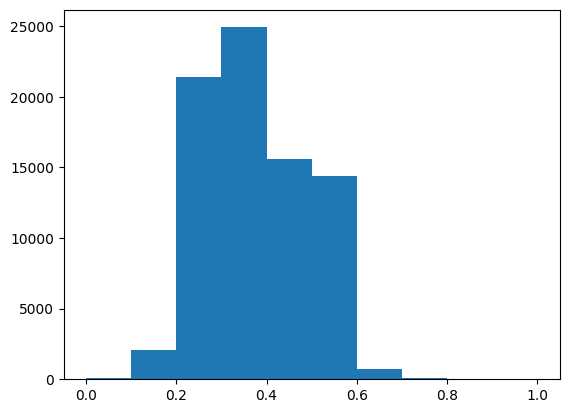

In [ ]:
plt.hist(x = l)

#The above plot helps us to understand the vowel ratio w.r.t the length of a word

In [ ]:
class hangman(object):

    def __init__(self):

      self.guessed_letters = []

      full_dictionary_location = "/content/words.txt"
      self.full_dictionary = self.build_dictionary(full_dictionary_location)
      self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()

      self.current_dictionary = []

      self.n_word_dictionary = self.build_n_word_dictionary(self.full_dictionary)

    def build_display_word(self, word, guessed_letters):
        display_word = ""
        for letter in word:
            if letter in guessed_letters:
                display_word += letter
            else:
                display_word += " _ "
        return display_word

    def build_n_word_dictionary(self, word_list):
        n_word_dict = {i: [] for i in range(3, 30)}
        max_length = self.find_max_length(word_list)

        count = 3
        while count <= max_length:
            for word in word_list:
                if len(word) >= count:
                    for i in range(len(word) - count + 1):
                        n_word_dict[count].append(word[i:i + count])
            count += 1

        return n_word_dict

    def find_max_length(self, word_list):
        max_length = 0
        for word in word_list:
            if len(word) > max_length:
                max_length = len(word)
        return max_length

    def build_dictionary(self, dictionary_file_location):
        with open(dictionary_file_location, "r") as text_file:
            full_dictionary = text_file.read().splitlines()
        return full_dictionary

    def vowel_count(self, clean_word):
        vowels = "aeiou"
        count = sum(1 for char in clean_word if char in vowels)
        return count / len(clean_word) if len(clean_word) > 0 else 0.0

    def func(self, new_dictionary):
        dictx = collections.Counter()
        for words in new_dictionary:
            temp = collections.Counter(words)
            for i in temp:
                temp[i] = 1
                dictx = dictx + temp
        return dictx

    def func2(self, n_word_dictionary, clean_word):
        new_dictionary = []
        l = len(clean_word)
        if l in n_word_dictionary:
          for dict_word in n_word_dictionary[l]:
              if re.match(clean_word, dict_word):
                  new_dictionary.append(dict_word)
        return new_dictionary

    def guess(self, word, n_word_dictionary):

        #building a dict that maps the most common letters w.r.t to word length e.g A[6] is a 6 letter word and
        # 'E I A O U S' are the common letters in a 6 letter word
        A = ['A I', 'A O E I U M B H', 'A E O I U Y H B C K', 'A E O I U Y S B F', 'S E A O I U Y H', 'E A I O U S Y',
             'E I A O U S', 'E I A O U', 'E I A O U', 'E I O A U', 'E I O A D', 'E I O A F', 'I E O A', 'I E O', 'I E A',
             'I E H', 'I E R', 'I E A', 'I E A', 'I E']

        for i in range(len(A)):
          A[i] = A[i].replace(' ', '').lower()

        letter_dict = {i: A[i-1] for i in range(1,21)}

        vowels = 'aeiou'

        clean_word = word[::2].replace("_",".")
        len_word = len(clean_word)
        current_dictionary = self.current_dictionary
        new_dictionary = []


        #setting the vowel_ratio THRESHOLD acc to the length of the word
        if len(clean_word) < 5:
          ratio = 0.25
        else:
            ratio = 0.19

        #Collecting the plausible words that match our guess word's length and pattern
        for dict_word in current_dictionary:
            if len(dict_word) != len_word:
                continue

            if re.match(clean_word,dict_word):
                new_dictionary.append(dict_word)

        self.current_dictionary = new_dictionary

        c = self.func(new_dictionary)
        sorted_letter_count = c.most_common()

        guess_letter = '!'

        #guessing letter based on the length of the word
        if guess_letter =="!":
          for letter in letter_dict[len(clean_word)]:
            if letter not in self.guessed_letters:
                    if letter in vowels and self.vowel_count(clean_word) > ratio:
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    break

        #guessing letter based on the letter frequency w.r.t length of guess word (Bag Of Words)
        if guess_letter == '!':
          for letter, instance_count in sorted_letter_count:
              if letter not in self.guessed_letters:
                  if letter in vowels and self.vowel_count(clean_word) > ratio:
                      self.guessed_letters.append(letter)
                      continue
                  guess_letter = letter
                  break

      #guessing based on n-grams
        if guess_letter == '!':
            new_dictionary = self.func2(n_word_dictionary, clean_word)
            c = self.func(new_dictionary)
            sorted_letter_count = c.most_common()
            for letter, instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    if letter in vowels and self.vowel_count(clean_word) > ratio:
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    break


        if guess_letter == '!':
            x = int(len(clean_word) / 2)
            if x >= 3:
                c = collections.Counter()
                for i in range(len(clean_word) - x + 1):
                    s = clean_word[i:i + x]
                    new_dictionary = self.func2(n_word_dictionary, s)
                    temp = self.func(new_dictionary)
                    c = c + temp
                sorted_letter_count = c.most_common()
                for letter, instance_count in sorted_letter_count:
                    if letter not in self.guessed_letters:
                        guess_letter = letter
                        break

        if guess_letter == '!':
            x = int(len(clean_word) / 3)
            if x >= 3:
                c = collections.Counter()
                for i in range(len(clean_word) - x + 1):
                    s = clean_word[i:i + x]
                    new_dictionary = self.func2(n_word_dictionary, s)
                    temp = self.func(new_dictionary)
                    c = c + temp
                sorted_letter_count = c.most_common()
                for letter, instance_count in sorted_letter_count:
                    if letter not in self.guessed_letters:
                        guess_letter = letter
                        break

        #fall-back fuction guessing based on frequeny of letters in words of given dictionary
        if guess_letter == '!':
            sorted_letter_count = self.full_dictionary_common_letter_sorted
            for letter, instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    if letter in vowels and self.vowel_count(clean_word) > ratio:
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    break


    #fall-back function guessing based on the most commonly used letters in english dictionary
        if guess_letter =="!":
          cl_order = 'esiarntolcdupmghbyfvkwzxqj'
          for letter in cl_order:
            if letter not in self.guessed_letters:
                  if letter in vowels and self.vowel_count(clean_word) > ratio:
                       self.guessed_letters.append(letter)
                       continue
                  guess_letter = letter
                  break


        return guess_letter

    def start_game(self, practice=True, verbose=True):
        word = random.choice(self.full_dictionary)
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary
        self.n_word_dictionary = self.build_n_word_dictionary(self.full_dictionary)

        attempts = 0
        max_attempts = 6  # Set your desired max attempts

        while attempts < max_attempts:
            display_word = self.build_display_word(word, self.guessed_letters)
            print(f"Current Word: {display_word}")

            guess_letter = self.guess(word, self.n_word_dictionary)
            self.guessed_letters.append(guess_letter)

            if guess_letter in word:
                print(f"Good guess! '{guess_letter}' is in the word.")
            else:
                print(f"Wrong guess! '{guess_letter}' is not in the word.")
                attempts += 1

            if set(word) == set(self.guessed_letters):
                print(f"Congratulations! You guessed the word: {word}")
                break

        if attempts == max_attempts:
            print(f"Sorry, you've reached the maximum attempts. The correct word was: {word}")




In [ ]:
game = hangman()

word = random.choice(game.full_dictionary)
game.start_game(word, verbose=True)

Current Word:  _  _  _  _  _  _  _  _ 
Good guess! 'a' is in the word.
Current Word:  _  _  _  _  _  _ a _ 
Good guess! 'e' is in the word.
Current Word:  _  _  _  _  _ ea _ 
Wrong guess! 'o' is not in the word.
Current Word:  _  _  _  _  _ ea _ 
Good guess! 'i' is in the word.
Current Word:  _ i _  _  _ ea _ 
Wrong guess! 'u' is not in the word.
Current Word:  _ i _  _  _ ea _ 
Wrong guess! 'y' is not in the word.
Current Word:  _ i _  _  _ ea _ 
Good guess! 's' is in the word.
Current Word:  _ is _  _ ea _ 
Wrong guess! 'b' is not in the word.
Current Word:  _ is _  _ ea _ 
Wrong guess! 'f' is not in the word.
Current Word:  _ is _  _ ea _ 
Good guess! 'r' is in the word.
Current Word:  _ is _ rea _ 
Wrong guess! 'n' is not in the word.
Sorry, you've reached the maximum attempts. The correct word was: mistreat
